# **A Deep Learning Approach for Intrusion Detection Using Recurrent Neural Networks**

> Binary - Attack and Normal type 

In [ ]:
# Linking Google drive to use preprocessed data 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import libraries
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from keras.layers import SimpleRNN

In [ ]:
## add the columns' name and read the KDDTrain and KDDTest datasets
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

print(col_names)

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']


## Dataset
The dataset covers the **KDDTrain** dataset as the training set and **KDDTest** and **KDDTest−21** datasets as the testing set, normal records and four different types of attack records.

In [ ]:

#Training set
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML-Jcomp/NSL_KDD_Train.csv",header=None, names = col_names)
# Testing set
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ML-Jcomp/NSL_KDD_Test.csv", header=None, names = col_names)

print('Training: ',df.shape)
print('Testing: ',df_test.shape)

FileNotFoundError: ignored

In [ ]:
df.head()

NameError: ignored

In [ ]:
df_test.head()

duration protocol_type  ... dst_host_srv_rerror_rate    label
0         0           tcp  ...                     1.00  neptune
1         0           tcp  ...                     1.00  neptune
2         2           tcp  ...                     0.00   normal
3         0          icmp  ...                     0.00    saint
4         1           tcp  ...                     0.71    mscan

[5 rows x 42 columns]

In [ ]:
print("Target for training set:")
print(df['label'].value_counts())

Target for training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64


In [ ]:
print("Target for testing set:")
print(df_test['label'].value_counts())

Target for testing set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
udpstorm              2
perl                  2
sqlattack             2
loadmodule            2
worm                  2
phf                   2
imap                  1
Name: label, dtype: int64


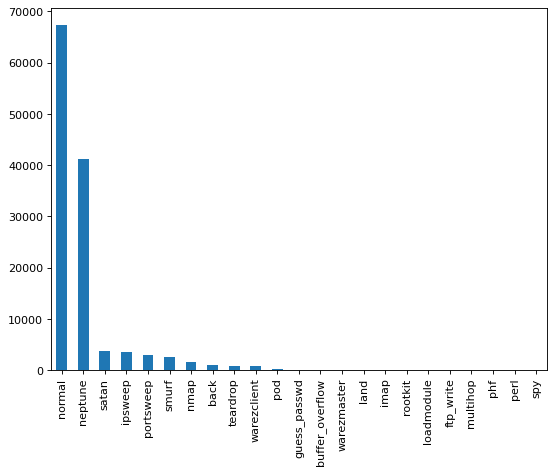

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

df['label'].value_counts().plot(kind='bar')


# Step 1: Data Preprocessing

## Numericalization
There are 38 numeric features and 3 nonnumeric features in the NSL-KDD dataset. Because the input value of RNN-IDS should be a numeric matrix, we must convert some nonnumeric features, such as ‘**protocol_type**’, ‘**service**’ and ‘**flag**’ features, into numeric form.

In [ ]:
print('Training set unique categories in column 2, 3 and 4:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("{col_name} : {unique_cat}".format(col_name=col_name, unique_cat=unique_cat))

Training set unique categories in column 2, 3 and 4:
protocol_type : 3
service : 70
flag : 11
label : 23


In [ ]:
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
print('Distribution of categories in flag:')
print(df['flag'].value_counts().sort_values(ascending=False).head())

Distribution of categories in flag:
SF      74945
S0      34851
REJ     11233
RSTR     2421
RSTO     1562
Name: flag, dtype: int64


In [ ]:
print('Distribution of categories in label:')
print(df['label'].value_counts().sort_values(ascending=False).head())

Distribution of categories in label:
normal       67343
neptune      41214
satan         3633
ipsweep       3599
portsweep     2931
Name: label, dtype: int64


In [ ]:
## Similarly for the test dataset
# Test set
print('Test set unique categories in column 2, 3 and 4:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("{col_name} : {unique_cat}".format(col_name=col_name, unique_cat=unique_cat))

Test set unique categories in column 2, 3 and 4:
protocol_type : 3
service : 64
flag : 11
label : 38


### Label Encoder : Converting the categorical values to numerica values

In [ ]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
unique_protocol2=[x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
unique_service2=[x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
unique_flag2=[x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2



['icmp', 'tcp', 'udp']
['IRC', 'X11', 'Z39_50', 'aol', 'auth', 'bgp', 'courier', 'csnet_ns', 'ctf', 'daytime', 'discard', 'domain', 'domain_u', 'echo', 'eco_i', 'ecr_i', 'efs', 'exec', 'finger', 'ftp', 'ftp_data', 'gopher', 'harvest', 'hostnames', 'http', 'http_2784', 'http_443', 'http_8001', 'imap4', 'iso_tsap', 'klogin', 'kshell', 'ldap', 'link', 'login', 'mtp', 'name', 'netbios_dgm', 'netbios_ns', 'netbios_ssn', 'netstat', 'nnsp', 'nntp', 'ntp_u', 'other', 'pm_dump', 'pop_2', 'pop_3', 'printer', 'private', 'red_i', 'remote_job', 'rje', 'shell', 'smtp', 'sql_net', 'ssh', 'sunrpc', 'supdup', 'systat', 'telnet', 'tftp_u', 'tim_i', 'time', 'urh_i', 'urp_i', 'uucp', 'uucp_path', 'vmnet', 'whois']
['OTH', 'REJ', 'RSTO', 'RSTOS0', 'RSTR', 'S0', 'S1', 'S2', 'S3', 'SF', 'SH']


In [ ]:
print(len(unique_protocol2))
print(len(unique_service2))
print(len(unique_flag2))

3
70
11


In [ ]:
#do it for test set
#service
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[x for x in unique_service_test]

#protocol
unique_protocol_test=sorted(df_test.protocol_type.unique())
unique_protocol2_test=[x for x in unique_protocol_test]

#flag
unique_flag_test=sorted(df_test.flag.unique())
unique_flag2_test=[x for x in unique_flag_test]

testdumcols=unique_protocol2_test + unique_service2_test + unique_flag2_test

In [ ]:
print(len(unique_protocol2_test))
print(len(unique_service2_test))
print(len(unique_flag2_test))

3
64
11


In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical = df[categorical_columns]
# for Test
testdf_categorical = df_test[categorical_columns]

df_categorical_enc=df_categorical.apply(LabelEncoder().fit_transform)

print(df_categorical.head())

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF


In [ ]:
## after label encoding
print(df_categorical_enc.head())

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


In [ ]:
# test set
testdf_categorical_enc=testdf_categorical.apply(LabelEncoder().fit_transform)
print(testdf_categorical_enc.head())

   protocol_type  service  flag
0              1       45     1
1              1       45     1
2              1       19     9
3              0       13     9
4              1       55     2


In [ ]:
print('Training: ',df_categorical_enc.shape)
print('Testing:',testdf_categorical_enc.shape)

Training:  (125973, 3)
Testing: (22544, 3)


### one-hot encoding
These numeric values are then encoded as binary vectors (1,0,0), (0,1,0) and (0,0,1) using one-hot encoding

In [ ]:
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_enc)
df_onehot_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
df_onehot_data.head()

icmp  tcp  udp  IRC  X11  Z39_50  aol  ...  RSTR   S0   S1   S2   S3   SF   SH
0   0.0  1.0  0.0  0.0  0.0     0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  1.0  0.0
1   0.0  0.0  1.0  0.0  0.0     0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  1.0  0.0
2   0.0  1.0  0.0  0.0  0.0     0.0  0.0  ...   0.0  1.0  0.0  0.0  0.0  0.0  0.0
3   0.0  1.0  0.0  0.0  0.0     0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  1.0  0.0
4   0.0  1.0  0.0  0.0  0.0     0.0  0.0  ...   0.0  0.0  0.0  0.0  0.0  1.0  0.0

[5 rows x 84 columns]

In [ ]:
# test set
enc = OneHotEncoder(categories='auto')
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_enc)
testdf_onehot_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)
testdf_onehot_data.head()

icmp  tcp  udp  IRC  X11  Z39_50  auth  ...  RSTR   S0   S1   S2   S3   SF   SH
0   0.0  1.0  0.0  0.0  0.0     0.0   0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0
1   0.0  1.0  0.0  0.0  0.0     0.0   0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0
2   0.0  1.0  0.0  0.0  0.0     0.0   0.0  ...   0.0  0.0  0.0  0.0  0.0  1.0  0.0
3   1.0  0.0  0.0  0.0  0.0     0.0   0.0  ...   0.0  0.0  0.0  0.0  0.0  1.0  0.0
4   0.0  1.0  0.0  0.0  0.0     0.0   0.0  ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0

[5 rows x 78 columns]

In [ ]:
# print('Training onehot df: ',df_onehot_data.shape)
print('Testing onehot df:',testdf_onehot_data.shape)

Testing onehot df: (22544, 78)


In [ ]:
# Since the testdf had 6 columns less in the service, we add the missing values 
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
difference=[x for x in difference]

for col in difference:
    testdf_onehot_data[col] = 0

print(df_onehot_data.shape)    
print(testdf_onehot_data.shape)

(125973, 84)
(22544, 84)


- add this into original dataframe
- drop the columns
- add attack types
- onehot-encoding for attack types
- total 122 features
- build RNN model
- predict and accuracy

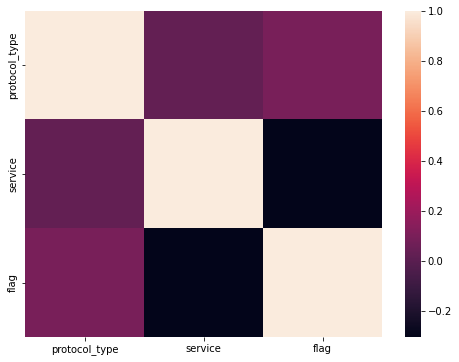

In [ ]:
# df = df.dropna('columns')# drop columns with NaN

# df = df[[col for col in df if df[col].nunique() > 1]]# keep columns where there are more than 1 unique values
# test df correlation between values
corr = df_categorical_enc.corr()
plt.figure(figsize=(8,6))
sb.heatmap(corr)
plt.show()

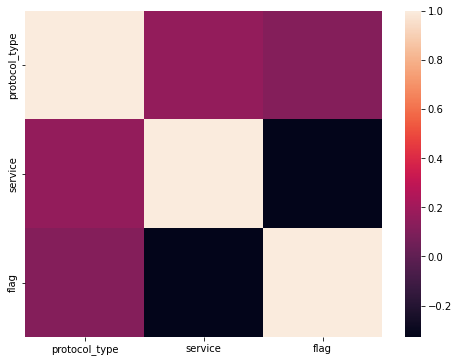

In [ ]:
corr = testdf_categorical_enc.corr()
plt.figure(figsize=(8,6))
sb.heatmap(corr)
plt.show()

In [ ]:
traindf=df.join(df_onehot_data)
traindf.drop('flag', axis=1, inplace=True)
traindf.drop('protocol_type', axis=1, inplace=True)
traindf.drop('service', axis=1, inplace=True)
print(traindf.shape)
traindf.head()

(125973, 123)


duration  src_bytes  dst_bytes  land  ...   S2   S3   SF   SH
0         0        491          0     0  ...  0.0  0.0  1.0  0.0
1         0        146          0     0  ...  0.0  0.0  1.0  0.0
2         0          0          0     0  ...  0.0  0.0  0.0  0.0
3         0        232       8153     0  ...  0.0  0.0  1.0  0.0
4         0        199        420     0  ...  0.0  0.0  1.0  0.0

[5 rows x 123 columns]

In [ ]:
# test data
testdf=df_test.join(testdf_onehot_data)
testdf.drop('flag', axis=1, inplace=True)
testdf.drop('protocol_type', axis=1, inplace=True)
testdf.drop('service', axis=1, inplace=True)
print(testdf.shape)
testdf.head()

(22544, 123)


duration  src_bytes  dst_bytes  land  ...  harvest  aol  red_i  http_2784
0         0          0          0     0  ...        0    0      0          0
1         0          0          0     0  ...        0    0      0          0
2         2      12983          0     0  ...        0    0      0          0
3         0         20          0     0  ...        0    0      0          0
4         1          0         15     0  ...        0    0      0          0

[5 rows x 123 columns]

# Step 2: Normalization

### 1. Feature Scaling
First, according to some features, suchas ‘duration[0,58329]’, ‘src_bytes[0,1.3 × 109]’ and ‘dst_bytes[0,1.3 × 109]’, where the difference between the maximum and minimum values has a very large scope, we apply the logarithmic scaling method for scaling to obtain the ranges of ‘duration[0,4.77]’, ‘src_bytes[0,9.11]’ and ‘dst_bytes[0,9.11]’

In [ ]:
log2_duration = []
for i in traindf['duration']:
  if(i==0):
    log2_duration.append(0)
  else:
    log2_duration.append(np.log2(i))

print(log2_duration)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12.453013354466314, 0, 8.985841937003341, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0, 1.0, 13.144020869266893, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.29920801838728, 0, 0, 0, 0, 0, 1.0, 0, 0, 10.079484783826816, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 14.663446918132605, 0, 0, 0, 0, 0, 0, 0, 7.906890595608519, 0, 0, 0, 0.0, 0, 4.700439718141092, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 13.138111776319704, 2.807354922057604, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 13.887886965339108, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 2.0, 0, 0, 0, 0, 0, 0, 0, 4.321928094887363, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4.169925001442312, 0, 13.1728962458

In [ ]:
log2_src_bytes = []
for i in traindf['src_bytes']:
  if(i==0):
    log2_src_bytes.append(0)
  else:
    log2_src_bytes.append(np.log2(i))

print(log2_src_bytes)

[8.939579214314692, 7.189824558880018, 0, 7.857980995127572, 7.636624620543649, 0, 0, 0, 0, 0, 0, 0, 8.164906926675688, 8.383704292474052, 0, 0, 8.228818690495881, 4.169925001442312, 7.86418614465428, 8.422064766172813, 0, 0, 7.98299357469431, 7.199672344836364, 0, 8.7714894695006, 0, 7.826548487290915, 7.7481928495894605, 7.912889336229962, 3.0, 0, 8.243173983472952, 0, 5.491853096329675, 6.714245517666122, 5.426264754702098, 0, 8.339850002884624, 0, 0, 0, 10.635718120331047, 7.189824558880018, 8.179909090014934, 0, 4.807354922057604, 7.994353436858858, 8.383704292474052, 0, 8.238404739325079, 0, 4.807354922057604, 7.78135971352466, 5.426264754702098, 5.459431618637297, 3.0, 0, 0, 5.426264754702098, 9.324180546618742, 0, 0, 8.276124405274238, 0, 9.442943495848729, 0, 0, 0, 0, 7.787902559391432, 0, 7.499845887083206, 5.392317422778761, 0, 3.584962500721156, 0, 7.714245517666122, 8.326429487122303, 0, 8.361943773735241, 0, 0, 3.0, 8.321928094887362, 0, 7.813781191217037, 0, 0, 7.1898245

In [ ]:
log2_dst_bytes = []
for i in traindf['dst_bytes']:
  if(i==0):
    log2_dst_bytes.append(0)
  else:
    log2_dst_bytes.append(np.log2(i))

print(log2_dst_bytes)

[0, 0, 0, 12.993115299679177, 8.714245517666123, 0, 0, 0, 0, 0, 0, 0, 11.136350341454156, 0, 0, 0, 13.75112558336727, 0, 9.266786540694902, 10.20212382383046, 0, 0, 13.539280000157696, 6.714245517666122, 0, 13.815883588859052, 0, 12.685624839726355, 13.357964301369893, 10.451211111832329, 0, 0, 9.116343961237469, 0, 5.491853096329675, 7.199672344836364, 5.426264754702098, 0, 11.16867211813223, 0, 0, 0, 8.539158811108031, 6.714245517666122, 11.553629293916364, 0, 0, 9.749869427396844, 0, 0, 8.960001932068081, 0, 0, 10.449148645375436, 6.108524456778169, 7.05528243550119, 0, 0, 0, 5.426264754702098, 0, 0, 0, 11.448116305409464, 0, 8.379378367071261, 0, 0, 0, 0, 11.490850876740298, 0, 0, 5.392317422778761, 0, 0, 0, 11.44604940671655, 12.472437000051329, 0, 11.959277505720502, 0, 0, 0, 8.566054038171092, 0, 11.877284133523196, 0, 0, 6.714245517666122, 10.467605550082997, 10.53430288245463, 5.459431618637297, 0, 0, 8.370687406807217, 6.672425341971495, 9.550746785383243, 6.714245517666122, 

In [ ]:
# step1: apply the logarithmic scaling method for scaling to obtain the ranges of `duration[0,4.77]', `src_bytes[0,9.11]' and `dst_bytes[0,9.11]
traindf['log2_duration'] = log2_duration
traindf['log2_src_bytes'] = log2_src_bytes
traindf['log2_dst_bytes'] = log2_dst_bytes

traindf=traindf.drop(['duration','src_bytes','dst_bytes'], axis=1)
print(traindf.shape)
print(traindf)

(125973, 123)
        land  wrong_fragment  ...  log2_src_bytes  log2_dst_bytes
0          0               0  ...        8.939579        0.000000
1          0               0  ...        7.189825        0.000000
2          0               0  ...        0.000000        0.000000
3          0               0  ...        7.857981       12.993115
4          0               0  ...        7.636625        8.714246
...      ...             ...  ...             ...             ...
125968     0               0  ...        0.000000        0.000000
125969     0               0  ...        6.714246        7.179909
125970     0               0  ...       11.123475        8.584963
125971     0               0  ...        0.000000        0.000000
125972     0               0  ...        7.238405        0.000000

[125973 rows x 123 columns]


In [ ]:
# similarly for the testdf
log2_duration_test = []
for i in testdf['duration']:
  if(i==0):
    log2_duration_test.append(0)
  else:
    log2_duration_test.append(np.log2(i))

print(log2_duration_test)

[0, 0, 1.0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5.20945336562895, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9.65284497300198, 0, 0, 0, 0, 0, 0, 3.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8.139551352398794, 0, 0, 0, 12.858758099935422, 0, 2.0, 8.129283016944967, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12.982280604558284, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.584962500721156, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0, 4.954196310386875, 0, 0, 0, 0, 0, 12.980139577639157, 12.987974524296153, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12.883025068440173, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.02167404285837, 0, 0, 0, 0, 12.86611979330307, 0, 0, 0, 0.0, 0, 0, 12.995943767764953, 0, 0, 0, 0, 0, 0, 0, 8.139551352398794, 0, 0, 8.134426320220927, 0, 0, 12.877667574067882, 0, 0, 0, 11.02167404285837, 0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 2.0, 0, 0, 0, 0, 0, 12.874597192401634, 0, 0, 0, 0, 4.754887502163468, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11.014717929860009, 0, 0,

In [ ]:
log2__src_bytes_test = []
for i in testdf['src_bytes']:
  if(i==0):
    log2__src_bytes_test.append(0)
  else:
    log2__src_bytes_test.append(np.log2(i))

print(log2__src_bytes_test)

[0, 0, 13.664336166972465, 4.321928094887363, 0, 8.060695931687555, 9.997179480937621, 7.011227255423254, 8.353146825498083, 4.700439718141092, 0, 9.266786540694902, 0, 0, 9.594324603924848, 8.451211111832329, 7.734709620225838, 7.94251450533924, 5.491853096329675, 0, 0, 0, 7.614709844115208, 8.113742166049189, 0, 0, 8.199672344836364, 8.228818690495881, 9.022367813028454, 5.754887502163468, 16.231521210875705, 9.491853096329674, 8.233619676759702, 0.0, 0, 0, 7.7073591320808825, 7.78135971352466, 5.426264754702098, 16.43146495782059, 0, 8.113742166049189, 8.326429487122303, 8.388017285345136, 0, 7.870364719583405, 0, 15.735027079802625, 0, 5.523561956057013, 8.312882955284355, 8.0, 0, 0, 7.321928094887363, 7.839203788096944, 0, 6.714245517666122, 0, 8.139551352398794, 4.807354922057604, 18.11358957149472, 7.86418614465428, 8.005624549193879, 0, 7.7414669864011465, 0, 0, 0, 7.6653359171851765, 0, 0, 8.262094845370179, 8.321928094887362, 0, 7.7481928495894605, 8.483815777264256, 0, 8.076

In [ ]:
log2_dst_bytes_test = []
for i in testdf['dst_bytes']:
  if(i==0):
    log2_dst_bytes_test.append(0)
  else:
    log2_dst_bytes_test.append(np.log2(i))

print(log2_dst_bytes_test)

[0, 0, 0, 0, 3.9068905956085187, 13.825256951514024, 8.59618975614441, 7.442943495848728, 8.867278739709661, 7.294620748891627, 0, 8.366322214245816, 0, 0, 18.474371396751565, 11.817783121774534, 9.364134655008051, 11.029287226968245, 5.459431618637297, 0, 0, 0, 10.832098846039134, 10.826548487290914, 0, 0, 12.653292945382814, 8.78135971352466, 0, 5.672425341971495, 0.0, 8.134426320220927, 14.272775563286087, 0.0, 0, 5.459431618637297, 13.65441226814894, 9.426264754702098, 6.149747119504682, 0, 0, 12.278449458220482, 11.406736482691723, 11.656424863277781, 0, 11.659995892429977, 0, 13.021327032624372, 0, 5.491853096329675, 8.930737337562887, 12.266200912498961, 0, 0, 9.226412192788786, 8.991521846075695, 0, 7.189824558880018, 5.459431618637297, 8.62935662007961, 6.539158811108031, 0, 11.128638812852598, 13.088788238716907, 0, 9.333155350310616, 0, 0, 0, 9.346513733165635, 0, 6.3750394313469245, 8.918863237274595, 10.703038388986418, 0, 8.74819284958946, 11.84979602224561, 3.90689059560

Problem: divide by zero encountered in log2, getting -inf values

In [ ]:
# step1: apply the logarithmic scaling method for scaling to obtain the ranges of `duration[0,4.77]', `src_bytes[0,9.11]' and `dst_bytes[0,9.11]
testdf['log2_duration'] = log2_duration_test
testdf['log2_src_bytes'] = log2__src_bytes_test
testdf['log2_dst_bytes'] = log2_dst_bytes_test

testdf=testdf.drop(['duration','src_bytes','dst_bytes'], axis=1)
print(testdf.shape)
print(testdf)

(22544, 123)
       land  wrong_fragment  ...  log2_src_bytes  log2_dst_bytes
0         0               0  ...        0.000000        0.000000
1         0               0  ...        0.000000        0.000000
2         0               0  ...       13.664336        0.000000
3         0               0  ...        4.321928        0.000000
4         0               0  ...        0.000000        3.906891
...     ...             ...  ...             ...             ...
22539     0               0  ...        9.632995        8.379378
22540     0               0  ...        8.308339        9.873444
22541     0               0  ...       15.735027       13.021327
22542     0               0  ...        5.392317        5.392317
22543     0               0  ...        0.000000        0.000000

[22544 rows x 123 columns]


In [ ]:
traindf.head()

land  wrong_fragment  urgent  ...  log2_duration  log2_src_bytes  log2_dst_bytes
0     0               0       0  ...            0.0        8.939579        0.000000
1     0               0       0  ...            0.0        7.189825        0.000000
2     0               0       0  ...            0.0        0.000000        0.000000
3     0               0       0  ...            0.0        7.857981       12.993115
4     0               0       0  ...            0.0        7.636625        8.714246

[5 rows x 123 columns]

In [ ]:
testdf.head()

land  wrong_fragment  urgent  ...  log2_duration  log2_src_bytes  log2_dst_bytes
0     0               0       0  ...            0.0        0.000000        0.000000
1     0               0       0  ...            0.0        0.000000        0.000000
2     0               0       0  ...            1.0       13.664336        0.000000
3     0               0       0  ...            0.0        4.321928        0.000000
4     0               0       0  ...            0.0        0.000000        3.906891

[5 rows x 123 columns]

### Min-max normalization
The value of every feature is mapped to the [0,1] range
linearly, where Max denotes the maximum
value and Min denotes minimum value for each feature

The dataset was divided into separate datasets for each attack category. Attack tags have been renamed for each. 
- 0 = Normal
- 1 = DoS 
- 2 = Probe 
- 3 = R2L
- 4 = U2R

In the new datasets, the tag column has been replaced with the new values.

In [ ]:
labeldf=traindf['label']
labeldf_test=testdf['label']

# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                            'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

In [ ]:
#put the new label column back
traindf['label'] = newlabeldf
testdf['label'] = newlabeldf_test

In [ ]:
traindf.head()

land  wrong_fragment  urgent  ...  log2_duration  log2_src_bytes  log2_dst_bytes
0     0               0       0  ...            0.0        8.939579        0.000000
1     0               0       0  ...            0.0        7.189825        0.000000
2     0               0       0  ...            0.0        0.000000        0.000000
3     0               0       0  ...            0.0        7.857981       12.993115
4     0               0       0  ...            0.0        7.636625        8.714246

[5 rows x 123 columns]

In [ ]:
testdf.head()

land  wrong_fragment  urgent  ...  log2_duration  log2_src_bytes  log2_dst_bytes
0     0               0       0  ...            0.0        0.000000        0.000000
1     0               0       0  ...            0.0        0.000000        0.000000
2     0               0       0  ...            1.0       13.664336        0.000000
3     0               0       0  ...            0.0        4.321928        0.000000
4     0               0       0  ...            0.0        0.000000        3.906891

[5 rows x 123 columns]

In [ ]:
newlabeldf.head()

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64

In [ ]:
print('Distribution of categories in service:')
print(newlabeldf.value_counts().sort_values(ascending=False).head())

Distribution of categories in service:
0    67343
1    45927
2    11656
3      995
4       52
Name: label, dtype: int64


# Further steps:
**for binary classification**
- Normal - 0
- Anomaly - 1,2,3,4

**for multiclass classification**
proceed with the classes of 0,1,2,3,4

In [ ]:
# making all normal to 0 and the rest anomalous as 1

#traindf
target = []
for i in traindf['label']:
  if(i==0):
    target.append(0)
  else:
    target.append(1)

print(target)
traindf['target'] = target
traindf = traindf.drop(['label'],axis=1)
traindf.head()

[0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 

land  wrong_fragment  urgent  ...  log2_src_bytes  log2_dst_bytes  target
0     0               0       0  ...        8.939579        0.000000       0
1     0               0       0  ...        7.189825        0.000000       0
2     0               0       0  ...        0.000000        0.000000       1
3     0               0       0  ...        7.857981       12.993115       0
4     0               0       0  ...        7.636625        8.714246       0

[5 rows x 123 columns]

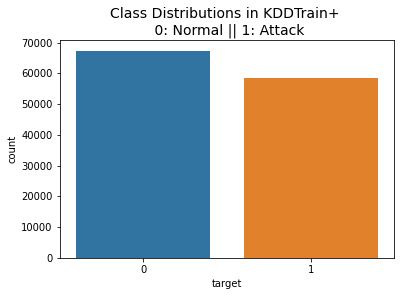

In [ ]:
sb.countplot(x="target", data=traindf)
plt.title('Class Distributions in KDDTrain+ \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

In [ ]:
#testdf
target_test = []
for i in testdf['label']:
  if(i==0):
    target_test.append(0)
  else:
    target_test.append(1)

print(target_test)
testdf['target'] = target_test
testdf = testdf.drop(['label'],axis=1)
testdf.head()

[1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 

land  wrong_fragment  urgent  ...  log2_src_bytes  log2_dst_bytes  target
0     0               0       0  ...        0.000000        0.000000       1
1     0               0       0  ...        0.000000        0.000000       1
2     0               0       0  ...       13.664336        0.000000       0
3     0               0       0  ...        4.321928        0.000000       1
4     0               0       0  ...        0.000000        3.906891       1

[5 rows x 123 columns]

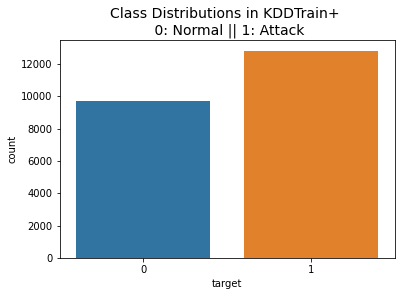

In [ ]:
sb.countplot(x="target", data=testdf)
plt.title('Class Distributions in KDDTrain+ \n 0: Normal || 1: Attack', fontsize=14)
plt.show()

## Splitting into x and y

### Training Df

In [ ]:
X_train = traindf.iloc[:,0:122]
Y_train = traindf['target']
print(X_train.shape)
print(Y_train.shape)

(125973, 122)
(125973,)


In [ ]:
print(X_train)

        land  wrong_fragment  ...  log2_src_bytes  log2_dst_bytes
0          0               0  ...        8.939579        0.000000
1          0               0  ...        7.189825        0.000000
2          0               0  ...        0.000000        0.000000
3          0               0  ...        7.857981       12.993115
4          0               0  ...        7.636625        8.714246
...      ...             ...  ...             ...             ...
125968     0               0  ...        0.000000        0.000000
125969     0               0  ...        6.714246        7.179909
125970     0               0  ...       11.123475        8.584963
125971     0               0  ...        0.000000        0.000000
125972     0               0  ...        7.238405        0.000000

[125973 rows x 122 columns]


In [ ]:
print(Y_train)

0         0
1         0
2         1
3         0
4         0
         ..
125968    1
125969    0
125970    0
125971    1
125972    0
Name: target, Length: 125973, dtype: int64


In [ ]:
# scaling
scale = MinMaxScaler()
scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scale.transform(X_train)
print(X_train_scaled)

[[-0.01408881 -0.08948642 -0.00773599 ... -0.21044482  0.99780899
  -0.86844855]
 [-0.01408881 -0.08948642 -0.00773599 ... -0.21044482  0.59286891
  -0.86844855]
 [-0.01408881 -0.08948642 -0.00773599 ... -0.21044482 -1.07104903
  -0.86844855]
 ...
 [-0.01408881 -0.08948642 -0.00773599 ... -0.21044482  1.50322092
   0.80846531]
 [-0.01408881 -0.08948642 -0.00773599 ... -0.21044482 -1.07104903
  -0.86844855]
 [-0.01408881 -0.08948642 -0.00773599 ... -0.21044482  0.60411166
  -0.86844855]]


### Testing Df

In [ ]:
X_test = testdf.iloc[:,0:122]
Y_test = testdf['target']
print(X_test.shape)
print(Y_test.shape)

(22544, 122)
(22544,)


In [ ]:
print(X_test)

       land  wrong_fragment  ...  log2_src_bytes  log2_dst_bytes
0         0               0  ...        0.000000        0.000000
1         0               0  ...        0.000000        0.000000
2         0               0  ...       13.664336        0.000000
3         0               0  ...        4.321928        0.000000
4         0               0  ...        0.000000        3.906891
...     ...             ...  ...             ...             ...
22539     0               0  ...        9.632995        8.379378
22540     0               0  ...        8.308339        9.873444
22541     0               0  ...       15.735027       13.021327
22542     0               0  ...        5.392317        5.392317
22543     0               0  ...        0.000000        0.000000

[22544 rows x 122 columns]


In [ ]:
print(Y_test)

0        1
1        1
2        0
3        1
4        1
        ..
22539    0
22540    0
22541    1
22542    0
22543    1
Name: target, Length: 22544, dtype: int64


In [ ]:
# scaling
scale = MinMaxScaler()
scale = preprocessing.StandardScaler().fit(X_test)
X_test_scaled=scale.transform(X_test)
print(X_test_scaled)

[[-0.01762386 -0.05910394 -0.01945925 ... -0.32761542 -1.14448688
  -1.04526721]
 [-0.01762386 -0.05910394 -0.01945925 ... -0.32761542 -1.14448688
  -1.04526721]
 [-0.01762386 -0.05910394 -0.01945925 ...  0.03048835  1.83845167
  -1.04526721]
 ...
 [-0.01762386 -0.05910394 -0.01945925 ... -0.32761542  2.29048561
   1.58136336]
 [-0.01762386 -0.05910394 -0.01945925 ... -0.32761542  0.03266153
   0.04245801]
 [-0.01762386 -0.05910394 -0.01945925 ... -0.32761542 -1.14448688
  -1.04526721]]


## Ensemble learning classification models: Random forest, Multi Layer Perceptron, SVM, Naive Bayes and Decision Tree

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

mlp = MLPClassifier(solver='adam', learning_rate_init = 0.005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=50)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

In [ ]:
#Test the models
for key, value in models.items():    
    model = value
    model.fit(X_train_scaled,Y_train)
    scores[key] = model.score(X_test_scaled, Y_test)

In [ ]:
# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 , inplace=True)
scores_frame.head()

Accuracy Score
NB         0.527502
RF         0.722897
SVM        0.780075
MLP        0.805802
J48        0.830687

Text(0.5, 0, 'Binary Classification')

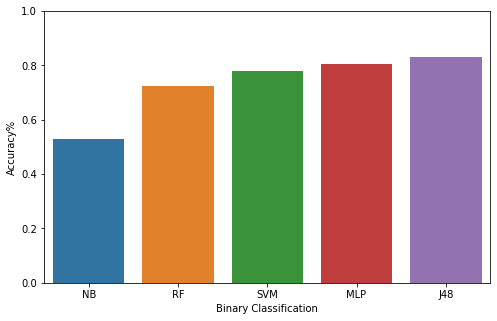

In [ ]:
plt.figure(figsize=(8,5))
sb.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("Binary Classification")

# Building the RNN model

In [ ]:
from tensorflow import keras
import numpy as np
import datetime
import time

sample = X_train_scaled.shape[0]
features = X_train_scaled.shape[1]
#Train: convert 2D to 3D for input RNN
x_train = np.reshape(X_train_scaled,(sample,features,1)) #shape  = (125973, 18, 1)
#Test: convert 2D to 3D for input RNN

x_test = testdf.values
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
print(x_train.shape)

(125973, 122, 1)


In [ ]:
print(Y_train.shape)

(125973,)


### Metrics list to evaluate the model

In [ ]:
import tensorflow as tf
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

### Custom Callback functions: recall, precision, f1_score

In [ ]:
import tensorflow.keras.backend as K
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

## RNN model 1: hidden node = 60, learning rate = 0.01

In [ ]:
from keras import optimizers 
model = Sequential()
model.add(SimpleRNN(60,input_shape=(features,x_train.shape[2]), activation='sigmoid'))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mae', recall,precision,f1_score])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60)                3720      
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 3,781
Trainable params: 3,781
Non-trainable params: 0
_________________________________________________________________


### training model 1

In [ ]:
mcp = ModelCheckpoint('RNN_binary2.h5')

In [ ]:
history = model.fit(x_train, Y_train, validation_split=0.33, epochs=15, batch_size= 32,callbacks=[mcp])  

Epoch 1/25
2638/2638 [==============================] - 75s 28ms/step - loss: 0.0668 - accuracy: 0.9167 - mae: 0.1478 - recall: 0.4782 - precision: 0.9966 - f1_score: 0.6407 - val_loss: 0.0552 - val_accuracy: 0.9239 - val_mae: 0.1276 - val_recall: 0.5254 - val_precision: 1.0000 - val_f1_score: 0.6842
Epoch 2/25
2638/2638 [==============================] - 74s 28ms/step - loss: 0.0510 - accuracy: 0.9328 - mae: 0.1257 - recall: 0.4806 - precision: 1.0000 - f1_score: 0.6441 - val_loss: 0.0521 - val_accuracy: 0.9278 - val_mae: 0.1134 - val_recall: 0.4538 - val_precision: 1.0000 - val_f1_score: 0.6190
Epoch 3/25
2638/2638 [==============================] - 73s 28ms/step - loss: 0.0475 - accuracy: 0.9411 - mae: 0.1115 - recall: 0.4919 - precision: 1.0000 - f1_score: 0.6551 - val_loss: 0.0436 - val_accuracy: 0.9429 - val_mae: 0.0976 - val_recall: 0.4870 - val_precision: 1.0000 - val_f1_score: 0.6500
Epoch 4/25
2638/2638 [==============================] - 73s 28ms/step - loss: 0.0406 - accurac

## RNN model 2: hidden node = 80, learning rate = 0.01

In [ ]:
from keras import optimizers 
model = Sequential()
model.add(SimpleRNN(80,input_shape=(features,x_train.shape[2]), activation='sigmoid'))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mae', recall,precision,f1_score])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 80)                6560      
                                                                 
 dense_1 (Dense)             (None, 1)                 81        
                                                                 
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mcp = ModelCheckpoint('RNN_binary.h5')

### training model 2

In [ ]:
history2 = model.fit(x_train, Y_train, validation_split=0.33, epochs=15, batch_size= 32,callbacks=[mcp]) 

Epoch 1/25
2638/2638 [==============================] - 81s 30ms/step - loss: 0.0645 - accuracy: 0.9177 - mae: 0.1490 - recall: 0.4779 - precision: 0.9977 - f1_score: 0.6409 - val_loss: 0.0522 - val_accuracy: 0.9262 - val_mae: 0.1050 - val_recall: 0.4711 - val_precision: 1.0000 - val_f1_score: 0.6352
Epoch 2/25
2638/2638 [==============================] - 80s 30ms/step - loss: 0.0499 - accuracy: 0.9350 - mae: 0.1216 - recall: 0.4812 - precision: 1.0000 - f1_score: 0.6443 - val_loss: 0.0456 - val_accuracy: 0.9393 - val_mae: 0.0990 - val_recall: 0.5039 - val_precision: 1.0000 - val_f1_score: 0.6652
Epoch 3/25
2638/2638 [==============================] - 80s 30ms/step - loss: 0.0447 - accuracy: 0.9441 - mae: 0.1084 - recall: 0.4880 - precision: 1.0000 - f1_score: 0.6508 - val_loss: 0.0386 - val_accuracy: 0.9528 - val_mae: 0.1048 - val_recall: 0.4809 - val_precision: 1.0000 - val_f1_score: 0.6444
Epoch 4/25
2638/2638 [==============================] - 80s 30ms/step - loss: 0.0317 - accurac

## RNN model 3: hidden node = 120, learning rate = 0.01

In [ ]:
from keras import optimizers 
model = Sequential()
model.add(SimpleRNN(120,input_shape=(features,x_train.shape[2]), activation='sigmoid'))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mae', recall,precision,f1_score])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 120)               14640     
                                                                 
 dense_2 (Dense)             (None, 1)                 121       
                                                                 
Total params: 14,761
Trainable params: 14,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mcp = ModelCheckpoint('RNN_binary3.h5')

### training model 3

In [ ]:
history3 = model.fit(x_train, Y_train, validation_split=0.33, epochs=15, batch_size= 32,callbacks=[mcp]) 

Epoch 1/25
2638/2638 [==============================] - 102s 38ms/step - loss: 0.0673 - accuracy: 0.9186 - mae: 0.1517 - recall: 0.4808 - precision: 0.9966 - f1_score: 0.6431 - val_loss: 0.0443 - val_accuracy: 0.9425 - val_mae: 0.1342 - val_recall: 0.5038 - val_precision: 1.0000 - val_f1_score: 0.6652
Epoch 2/25
2638/2638 [==============================] - 101s 38ms/step - loss: 0.0522 - accuracy: 0.9351 - mae: 0.1252 - recall: 0.4899 - precision: 1.0000 - f1_score: 0.6524 - val_loss: 0.0505 - val_accuracy: 0.9417 - val_mae: 0.1132 - val_recall: 0.5084 - val_precision: 1.0000 - val_f1_score: 0.6692
Epoch 3/25
2638/2638 [==============================] - 101s 38ms/step - loss: 0.0467 - accuracy: 0.9415 - mae: 0.1107 - recall: 0.4936 - precision: 1.0000 - f1_score: 0.6561 - val_loss: 0.0462 - val_accuracy: 0.9418 - val_mae: 0.1254 - val_recall: 0.4939 - val_precision: 1.0000 - val_f1_score: 0.6562
Epoch 4/25
2638/2638 [==============================] - 102s 39ms/step - loss: 0.0441 - acc

## comparing models for learning rate 0.01

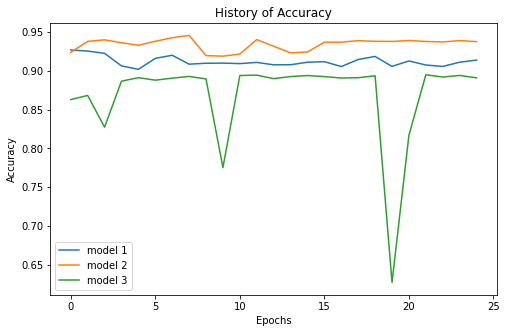

In [ ]:
fig, (ax1) = plt.subplots(figsize= (8,5))
plt.plot(history.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['model 1', 'model 2','model 3'])

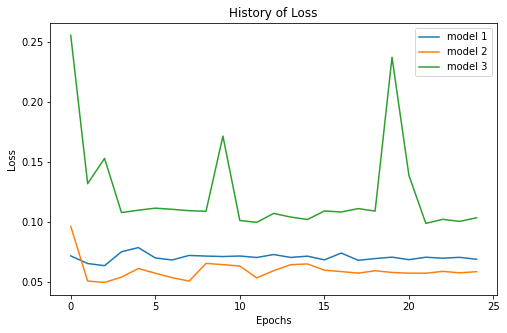

In [ ]:
fig, (ax1) = plt.subplots(figsize= (8,5))
plt.plot(history.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
ax1.set_title('History of Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['model 1', 'model 2','model 3'])

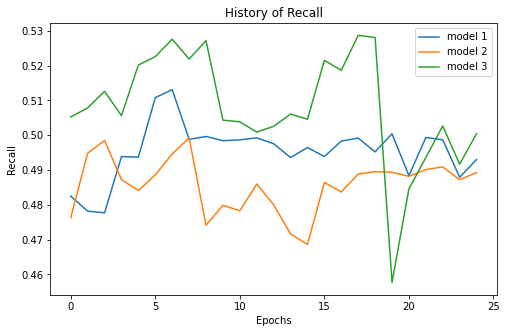

In [ ]:
fig, (ax1) = plt.subplots(figsize= (8,5))
plt.plot(history.history['recall'])
plt.plot(history2.history['recall'])
plt.plot(history3.history['recall'])
ax1.set_title('History of Recall')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Recall')
ax1.legend(['model 1', 'model 2','model 3'])

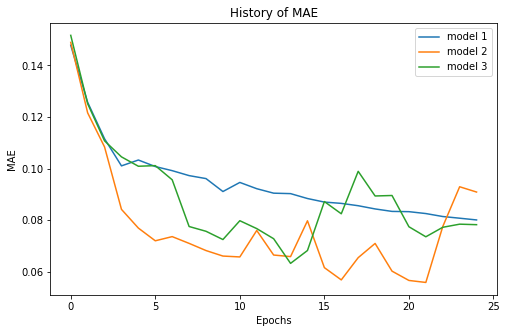

In [ ]:
fig, (ax1) = plt.subplots(figsize= (8,5))
plt.plot(history.history['mae'])
plt.plot(history2.history['mae'])
plt.plot(history3.history['mae'])
ax1.set_title('History of MAE')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE')
ax1.legend(['model 1', 'model 2','model 3'])

## RNN model 4: hidden node = 60, learning rate = 0.1

In [ ]:
from keras import optimizers 
model = Sequential()
model.add(SimpleRNN(60,input_shape=(features,x_train.shape[2]), activation='sigmoid'))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mae', recall,precision,f1_score])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 60)                3720      
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 3,781
Trainable params: 3,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mcp = ModelCheckpoint('RNN_binary4.h5')

In [ ]:
history = model.fit(x_train, Y_train, validation_split=0.33, epochs=15, batch_size= 32,callbacks=[mcp]) 

Epoch 1/25
2638/2638 [==============================] - 75s 28ms/step - loss: 0.0716 - accuracy: 0.9271 - mae: 0.1520 - recall: 0.4825 - precision: 0.9970 - f1_score: 0.6447 - val_loss: 0.0483 - val_accuracy: 0.9478 - val_mae: 0.1361 - val_recall: 0.4858 - val_precision: 1.0000 - val_f1_score: 0.6487
Epoch 2/25
2638/2638 [==============================] - 73s 28ms/step - loss: 0.0653 - accuracy: 0.9256 - mae: 0.1558 - recall: 0.4781 - precision: 1.0000 - f1_score: 0.6415 - val_loss: 0.0537 - val_accuracy: 0.9227 - val_mae: 0.1122 - val_recall: 0.4488 - val_precision: 1.0000 - val_f1_score: 0.6143
Epoch 3/25
2638/2638 [==============================] - 73s 28ms/step - loss: 0.0634 - accuracy: 0.9227 - mae: 0.1516 - recall: 0.4777 - precision: 1.0000 - f1_score: 0.6409 - val_loss: 0.0764 - val_accuracy: 0.9208 - val_mae: 0.1788 - val_recall: 0.5322 - val_precision: 1.0000 - val_f1_score: 0.6902
Epoch 4/25
2638/2638 [==============================] - 75s 28ms/step - loss: 0.0750 - accurac

## RNN model 5: hidden node = 80, learning rate = 0.1

In [ ]:
from keras import optimizers 
model = Sequential()
model.add(SimpleRNN(80,input_shape=(features,x_train.shape[2]), activation='sigmoid'))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mae', recall,precision,f1_score])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 80)                6560      
                                                                 
 dense_4 (Dense)             (None, 1)                 81        
                                                                 
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mcp = ModelCheckpoint('RNN_binary5.h5')

In [ ]:
history2 = model.fit(x_train, Y_train, validation_split=0.33, epochs=15, batch_size= 32,callbacks=[mcp]) 

Epoch 1/25
2638/2638 [==============================] - 83s 31ms/step - loss: 0.0962 - accuracy: 0.9239 - mae: 0.1439 - recall: 0.4763 - precision: 0.9939 - f1_score: 0.6387 - val_loss: 0.0475 - val_accuracy: 0.9307 - val_mae: 0.1024 - val_recall: 0.4763 - val_precision: 1.0000 - val_f1_score: 0.6401
Epoch 2/25
2638/2638 [==============================] - 82s 31ms/step - loss: 0.0506 - accuracy: 0.9381 - mae: 0.1220 - recall: 0.4948 - precision: 1.0000 - f1_score: 0.6573 - val_loss: 0.0558 - val_accuracy: 0.9427 - val_mae: 0.1693 - val_recall: 0.5010 - val_precision: 1.0000 - val_f1_score: 0.6626
Epoch 3/25
2638/2638 [==============================] - 83s 32ms/step - loss: 0.0495 - accuracy: 0.9401 - mae: 0.1201 - recall: 0.4984 - precision: 1.0000 - f1_score: 0.6604 - val_loss: 0.0487 - val_accuracy: 0.9402 - val_mae: 0.1290 - val_recall: 0.4881 - val_precision: 1.0000 - val_f1_score: 0.6510
Epoch 4/25
2638/2638 [==============================] - 83s 32ms/step - loss: 0.0539 - accurac

## RNN model 6: hidden node = 120, learning rate = 0.1

In [ ]:
from keras import optimizers 
model = Sequential()
model.add(SimpleRNN(120,input_shape=(features,x_train.shape[2]), activation='sigmoid'))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mae', recall,precision,f1_score])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 120)               14640     
                                                                 
 dense_5 (Dense)             (None, 1)                 121       
                                                                 
Total params: 14,761
Trainable params: 14,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mcp = ModelCheckpoint('RNN_binary5.h5')

In [ ]:
history3 = model.fit(x_train, Y_train, validation_split=0.33, epochs=15, batch_size= 32,callbacks=[mcp]) 

Epoch 1/25
2638/2638 [==============================] - 107s 40ms/step - loss: 0.2556 - accuracy: 0.8630 - mae: 0.2605 - recall: 0.5052 - precision: 0.9435 - f1_score: 0.6501 - val_loss: 0.0938 - val_accuracy: 0.9001 - val_mae: 0.1459 - val_recall: 0.5395 - val_precision: 1.0000 - val_f1_score: 0.6964
Epoch 2/25
2638/2638 [==============================] - 105s 40ms/step - loss: 0.1318 - accuracy: 0.8684 - mae: 0.2609 - recall: 0.5078 - precision: 0.9420 - f1_score: 0.6535 - val_loss: 0.0878 - val_accuracy: 0.8971 - val_mae: 0.1850 - val_recall: 0.5431 - val_precision: 1.0000 - val_f1_score: 0.6995
Epoch 3/25
2638/2638 [==============================] - 104s 39ms/step - loss: 0.1530 - accuracy: 0.8273 - mae: 0.2878 - recall: 0.5126 - precision: 0.8897 - f1_score: 0.6407 - val_loss: 0.4362 - val_accuracy: 0.5357 - val_mae: 0.4665 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 4/25
2638/2638 [==============================] - 104s 40ms/step - loss: 

## comparing models for learning rate 0.1

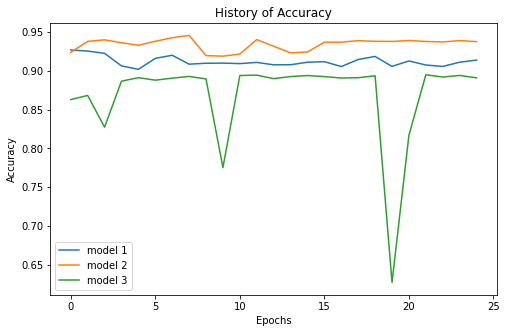

In [ ]:
fig, (ax1) = plt.subplots(figsize= (8,5))
plt.plot(history.history['accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history3.history['accuracy'])
ax1.set_title('History of Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(['model 1', 'model 2','model 3'])

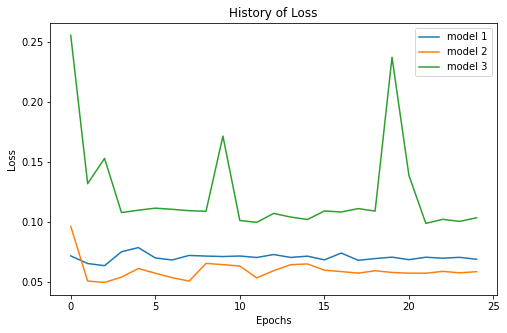

In [ ]:
fig, (ax1) = plt.subplots(figsize= (8,5))
plt.plot(history.history['loss'])
plt.plot(history2.history['loss'])
plt.plot(history3.history['loss'])
ax1.set_title('History of Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['model 1', 'model 2','model 3'])

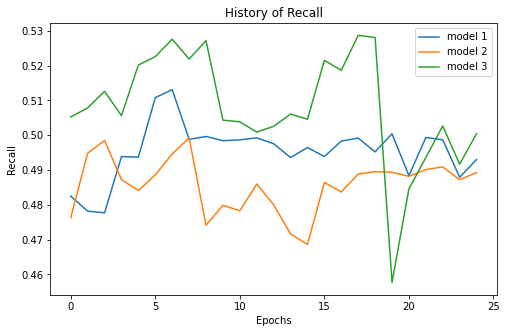

In [ ]:
fig, (ax1) = plt.subplots(figsize= (8,5))
plt.plot(history.history['recall'])
plt.plot(history2.history['recall'])
plt.plot(history3.history['recall'])
ax1.set_title('History of Recall')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Recall')
ax1.legend(['model 1', 'model 2','model 3'])

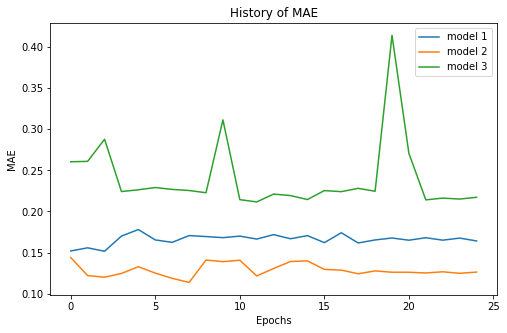

In [ ]:
fig, (ax1) = plt.subplots(figsize= (8,5))
plt.plot(history.history['mae'])
plt.plot(history2.history['mae'])
plt.plot(history3.history['mae'])
ax1.set_title('History of MAE')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAE')
ax1.legend(['model 1', 'model 2','model 3'])

## Enhancement - LSTM Model

In [ ]:
#Using tanh and sigmoid as activation functions in LSTM

Model = keras.Sequential([

        keras.layers.LSTM(80,input_shape=(features,x_train.shape[2]),activation='tanh',recurrent_activation='sigmoid'),
        keras.layers.Dense(1,activation="tanh")
    ])

Model.compile(optimizer='adam',loss='mse', metrics=['accuracy'])

#Training the model
hist = Model.fit(x_train, Y_train, epochs=25, batch_size= 128) 
Model.summary()

Epoch 1/10
985/985 [==============================] - 218s 219ms/step - loss: 0.0502 - accuracy: 0.9407
Epoch 2/10
985/985 [==============================] - 216s 219ms/step - loss: 0.0189 - accuracy: 0.9809
Epoch 3/10
985/985 [==============================] - 216s 219ms/step - loss: 0.0139 - accuracy: 0.9856
Epoch 4/10
985/985 [==============================] - 216s 219ms/step - loss: 0.0114 - accuracy: 0.9879
Epoch 5/10
985/985 [==============================] - 216s 219ms/step - loss: 0.0118 - accuracy: 0.9870
Epoch 6/10
985/985 [==============================] - 216s 219ms/step - loss: 0.0093 - accuracy: 0.9900
Epoch 7/10
985/985 [==============================] - 216s 219ms/step - loss: 0.0090 - accuracy: 0.9906
Epoch 8/10
985/985 [==============================] - 216s 219ms/step - loss: 0.0077 - accuracy: 0.9915
Epoch 9/10
985/985 [==============================] - 216s 219ms/step - loss: 0.0070 - accuracy: 0.9925
Epoch 10/10
985/985 [==============================] - 216s 219m

## RNN Model with tanh activation function

In [ ]:
#Using tanh and sigmoid as activation functions
model = Sequential()
model.add(SimpleRNN(80,input_shape=(features,x_train.shape[2]), activation='tanh'))
model.add(Dense(60, input_dim=122, activation='relu'))
model.add(Dense(1))
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mae', recall,precision,f1_score])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 80)                6560      
                                                                 
 dense_1 (Dense)             (None, 60)                4860      
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 11,481
Trainable params: 11,481
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mcp = ModelCheckpoint('LSTM_model.h5')

In [ ]:
history_lstm = model.fit(x_train, Y_train, validation_split=0.33, epochs=15, batch_size= 64 ,callbacks=[mcp]) 

Epoch 1/15
1319/1319 [==============================] - 43s 33ms/step - loss: 0.1777 - accuracy: 0.8510 - mae: 0.3046 - recall: 0.4657 - precision: 0.9257 - f1_score: 0.6080 - val_loss: 0.3644 - val_accuracy: 0.4645 - val_mae: 0.5613 - val_recall: 0.9994 - val_precision: 1.0000 - val_f1_score: 0.9997
Epoch 2/15
1319/1319 [==============================] - 43s 32ms/step - loss: 0.1374 - accuracy: 0.8835 - mae: 0.2591 - recall: 0.4678 - precision: 0.9659 - f1_score: 0.6229 - val_loss: 0.0765 - val_accuracy: 0.9165 - val_mae: 0.1993 - val_recall: 0.4651 - val_precision: 1.0000 - val_f1_score: 0.6324
Epoch 3/15
1319/1319 [==============================] - 43s 32ms/step - loss: 0.0824 - accuracy: 0.9144 - mae: 0.1821 - recall: 0.4708 - precision: 1.0000 - f1_score: 0.6373 - val_loss: 0.0729 - val_accuracy: 0.9041 - val_mae: 0.1558 - val_recall: 0.4810 - val_precision: 1.0000 - val_f1_score: 0.6472
Epoch 4/15
1319/1319 [==============================] - 43s 33ms/step - loss: 0.0670 - accurac

## Using LSTM model with tanh activation function

In [ ]:
#Using tanh and sigmoid as activation functions
from keras.layers import Dropout
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(80,input_shape=(features,x_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(80))
model.add(Dropout(0.2))
model.add(Dense(1, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'mae', recall,precision,f1_score])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 122, 80)           26240     
                                                                 
 dropout_2 (Dropout)         (None, 122, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 80)                51520     
                                                                 
 dropout_3 (Dropout)         (None, 80)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 81        
                                                                 
Total params: 77,841
Trainable params: 77,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:
mcp2 = ModelCheckpoint('new_model.h5')

In [ ]:
x_test = testdf.drop(columns='target').values
print(x_test.shape)

(22544, 122)


In [ ]:
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [ ]:
y_test = testdf.target
print(y_test)

0        1
1        1
2        0
3        1
4        1
        ..
22539    0
22540    0
22541    1
22542    0
22543    1
Name: target, Length: 22544, dtype: int64


In [ ]:
# Final evaluation of the model
scores = Model.evaluate(x_test, Y_test, verbose=0)
print("/n")
print("Accuracy: %.2f%%" % (scores[1]*100))

/n
Accuracy: 99.36%


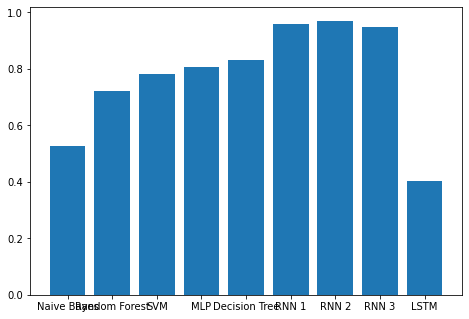

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
models = ['Naive Bayes', 'Random Forest', 'SVM', 'MLP', 'Decision Tree','RNN 1','RNN 2','RNN 3','LSTM']
accu = [0.527,0.722,0.78,0.805,0.8306,0.9593,0.9710,0.9475,0.4021]
ax.bar(models,accu)
plt.show()